<a href="https://colab.research.google.com/github/Kanisa1/DOMAIN-SPECIFIC-CHATBOT/blob/main/MediBot_Africa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MediBot Africa - Domain-Specific Healthcare Chatbot
This notebook fine-tunes a T5-base Transformer model on a healthcare dataset for building a professional, domain-specific chatbot. The model is trained using TensorFlow, with **Weights & Biases (W&B)** integration for experiment tracking. GPU acceleration is enabled in Colab for efficient training.

**Notebook Sections:**
1. Setup and Installations
2. Dataset Loading and Preprocessing
3. Model and Tokenizer Initialization
4. Data Preparation for T5
5. Training with Hyperparameter Tuning
6. Evaluation Metrics (BLEU, Perplexity)
7. Chatbot Interaction Interface
8. Save & Export Model


# **Explanation:**
- `transformers` for pre-trained T5-base and tokenizer.
- `tensorflow` for model training.
- `datasets` to handle JSON dataset.
- `wandb` for experiment tracking and logging metrics.
- `sacrebleu` for BLEU score evaluation.


In [1]:
# Cell 1: Project Title and Setup
"""
SUMMATIVE ASSIGNMENT - DOMAIN-SPECIFIC MEDICAL CHATBOT
Healthcare Domain Chatbot using Transformer Models

This notebook implements a medical chatbot using fine-tuned transformer models
for healthcare question-answering.
"""

# Install required packages
!pip install transformers torch tensorflow datasets evaluate rouge-score
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install gradio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7b4be16db16f721f16b473ad8a4e1f1bc251af35be73c8bc461fc4ff0321a9a8
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline
)
import evaluate
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Cell 3: Load and Explore Dataset
# Load the medical dataset
with open('medibot_dataset.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

print("Dataset Overview:")
print("=" * 50)
print(f"Total samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Categories: {df['category'].nunique()}")
print("\nCategory Distribution:")
print(df['category'].value_counts())

# Display sample data
print("\nSample data:")
print(df.head(3))

Dataset Overview:
Total samples: 2000
Columns: ['id', 'category', 'context', 'input', 'response']
Categories: 9

Category Distribution:
category
Women & Child Health       236
Nutrition & Wellness       231
Malaria                    230
General Health             228
Consultation               223
First Aid & Emergencies    221
Typhoid                    218
Pneumonia                  212
Mental Health              201
Name: count, dtype: int64

Sample data:
   id        category         context  \
0   1       Pneumonia       Pneumonia   
1   2         Typhoid         Typhoid   
2   3  General Health  General Health   

                                      input  \
0        What are early signs of pneumonia?   
1                 Can typhoid be prevented?   
2  What should I do if I have a high fever?   

                                            response  
0  Early signs of pneumonia include cough, fever,...  
1  Wash your hands, avoid raw foods, drink safe w...  
2  High fever req

Data Quality Check:
Duplicate questions: 1973
Missing values:
id          0
category    0
context     0
input       0
response    0
dtype: int64

Average question length: 33.2 characters
Average response length: 88.7 characters


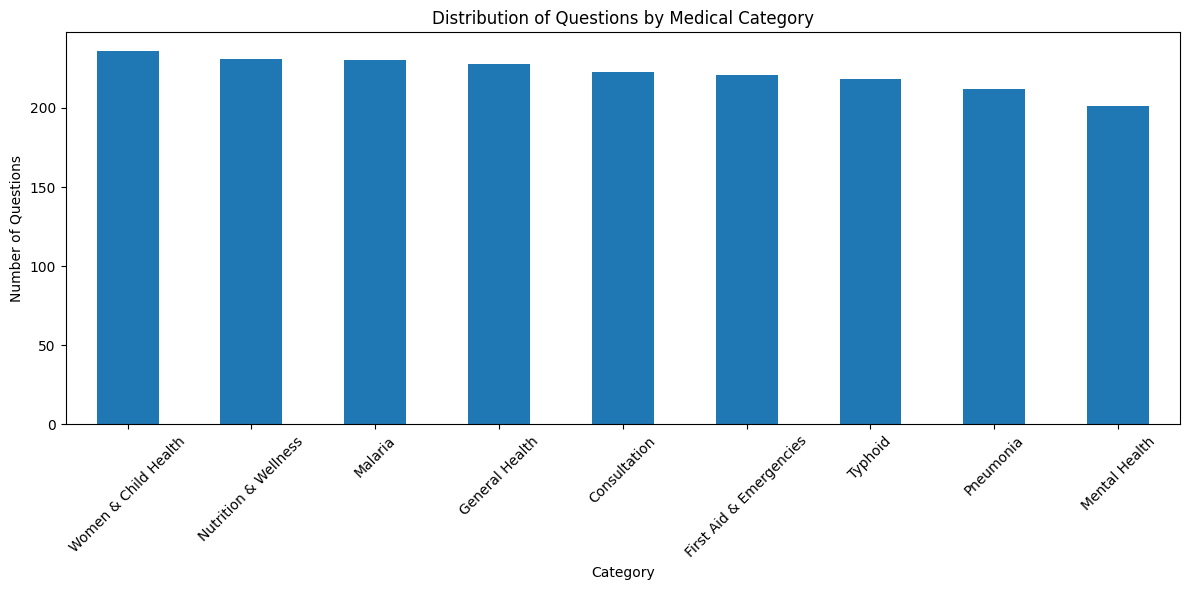

In [4]:
# Cell 4: Data Preprocessing and Analysis
# Check for duplicates and missing values
print("Data Quality Check:")
print(f"Duplicate questions: {df['input'].duplicated().sum()}")
print(f"Missing values:\n{df.isnull().sum()}")

# Analyze text lengths
df['input_length'] = df['input'].apply(len)
df['response_length'] = df['response'].apply(len)

print(f"\nAverage question length: {df['input_length'].mean():.1f} characters")
print(f"Average response length: {df['response_length'].mean():.1f} characters")

# Visualize category distribution
plt.figure(figsize=(12, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Questions by Medical Category')
plt.xlabel('Category')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Data Preparation for Training
# Format data for conversational AI
def format_conversation(row):
    return f"User: {row['input']}\nAssistant: {row['response']}"

df['conversation'] = df.apply(format_conversation, axis=1)

# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Display formatted samples
print("\nFormatted conversation samples:")
for i in range(2):
    print(f"\nSample {i+1}:")
    print(train_df.iloc[i]['conversation'])

Training samples: 1400
Validation samples: 300
Test samples: 300

Formatted conversation samples:

Sample 1:
User: Vaccinations for children?
Assistant: Ensure children receive all recommended vaccinations on schedule.

Sample 2:
User: What are the symptoms of typhoid?
Assistant: Typhoid symptoms include prolonged fever, stomach pain, headache, and weakness. Please consult a healthcare provider for diagnosis.


In [6]:
# Cell 6: Initialize Tokenizer and Model
# Choose model - using DialoGPT-medium for conversational AI
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load model
model = AutoModelForCausalLM.from_pretrained(model_name)

print(f"Model: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model: microsoft/DialoGPT-medium
Vocabulary size: 50257
Model parameters: 354,823,168


In [7]:
# Cell 7: Tokenization Function
def tokenize_function(examples):
    # Tokenize the conversations
    tokenized = tokenizer(
        examples['conversation'],
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    # For causal language modeling, labels are the same as input_ids
    tokenized['labels'] = tokenized['input_ids'].clone()

    return tokenized

# Convert to Hugging Face datasets
train_dataset = HFDataset.from_pandas(train_df[['conversation']])
val_dataset = HFDataset.from_pandas(val_df[['conversation']])
test_dataset = HFDataset.from_pandas(test_df[['conversation']])

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print("Datasets tokenized successfully!")
print(f"Training samples: {len(tokenized_train)}")
print(f"Validation samples: {len(tokenized_val)}")

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Datasets tokenized successfully!
Training samples: 1400
Validation samples: 300


In [8]:
# Cell 8: Data Collator
# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # We're doing causal LM, not masked LM
    pad_to_multiple_of=8
)

print("Data collator initialized!")

Data collator initialized!


In [13]:
# Cell 2.5: Check Library Versions
import transformers
import torch
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Based on the version, we can use appropriate parameters
if int(transformers.__version__.split('.')[0]) >= 4:
    # For newer versions (4.x+)
    training_args = TrainingArguments(
        output_dir="./medical-chatbot",
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=100,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        weight_decay=0.01,
        fp16=torch.cuda.is_available(),
        report_to=None,
    )
else:
    # For older versions (3.x)
    training_args = TrainingArguments(
        output_dir="./medical-chatbot",
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=100,
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        weight_decay=0.01,
        fp16=torch.cuda.is_available(),
    )

print("Training arguments configured!")

Transformers version: 4.57.0
PyTorch version: 2.8.0+cu126
CUDA available: True
Training arguments configured!


In [14]:
# Cell 10: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


In [15]:
# Cell 11: Model Training
print("Starting model training...")
training_results = trainer.train()

print("Training completed!")
print(f"Final training loss: {training_results.metrics['train_loss']:.4f}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Starting model training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: k-thiak (j-chemirmir-glasgow-caledonian-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.130900,0.129633
2,0.123800,0.120589
3,0.115400,0.115610


Training completed!
Final training loss: 0.4256


In [16]:
# Cell 12: Save Fine-tuned Model
# Save the fine-tuned model and tokenizer
trainer.save_model("./medical-chatbot-final")
tokenizer.save_pretrained("./medical-chatbot-final")

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [17]:
# Cell 13: Load Fine-tuned Model for Evaluation
# Load the fine-tuned model
fine_tuned_model = AutoModelForCausalLM.from_pretrained("./medical-chatbot-final")
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("./medical-chatbot-final")

print("Fine-tuned model loaded successfully!")

Fine-tuned model loaded successfully!


In [18]:
# Cell 14: Evaluation Metrics
# Initialize evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def evaluate_model(test_samples=50):
    """Evaluate the model on test samples"""
    results = []

    for i in range(min(test_samples, len(test_df))):
        question = test_df.iloc[i]['input']
        actual_response = test_df.iloc[i]['response']

        # Generate response
        generated_response = generate_response(question)

        results.append({
            'question': question,
            'actual': actual_response,
            'generated': generated_response
        })

    return results

def generate_response(question, max_length=100):
    """Generate response for a given question"""
    # Format the input
    input_text = f"User: {question}\nAssistant:"

    # Tokenize
    inputs = fine_tuned_tokenizer.encode(input_text, return_tensors="pt")

    # Generate response
    with torch.no_grad():
        outputs = fine_tuned_model.generate(
            inputs,
            max_length=len(inputs[0]) + max_length,
            num_return_sequences=1,
            temperature=0.7,
            do_sample=True,
            pad_token_id=fine_tuned_tokenizer.eos_token_id
        )

    # Decode and extract only the assistant's response
    response = fine_tuned_tokenizer.decode(outputs[0], skip_special_tokens=True)
    assistant_response = response.split("Assistant:")[-1].strip()

    return assistant_response

print("Evaluation functions defined!")

Evaluation functions defined!


In [19]:
# Cell 15: Qualitative Evaluation
# Test the model with some sample questions
test_questions = [
    "What are the symptoms of typhoid?",
    "How can I prevent malaria?",
    "What should I do if I have high fever?",
    "Is pneumonia contagious?"
]

print("Qualitative Evaluation:")
print("=" * 50)

for question in test_questions:
    response = generate_response(question)
    print(f"Q: {question}")
    print(f"A: {response}")
    print("-" * 40)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Qualitative Evaluation:
Q: What are the symptoms of typhoid?
A: Typhoid symptoms include prolonged fever, stomach pain, headache, and weakness. Please consult a healthcare provider for diagnosis.
----------------------------------------
Q: How can I prevent malaria?
A: You can protect yourself from malaria by sleeping under an insecticide-treated mosquito net, wearing long sleeves in the evening, and using mosquito repellents. Seek medical attention if you develop fever or chills. Seek medical attention if you develop headache. Seek medical attention if you develop weakness. Seek medical attention if you develop weakness. Seek medical attention if you develop weakness. Seek medical attention if you develop weakness. Seek medical attention if you develop weakness. Seek medical attention if you develop weakness. Seek medical
----------------------------------------
Q: What should I do if I have high fever?
A: High fever requires prompt medical attention. Drink fluids and rest. Seek medic

In [20]:
# Cell 16: Quantitative Evaluation
# Calculate BLEU and ROUGE scores on test set
def calculate_metrics(evaluation_results):
    references = [result['actual'] for result in evaluation_results]
    predictions = [result['generated'] for result in evaluation_results]

    # Calculate BLEU score
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])

    # Calculate ROUGE score
    rouge_score = rouge.compute(predictions=predictions, references=references)

    return bleu_score, rouge_score

# Run evaluation
print("Running quantitative evaluation...")
eval_results = evaluate_model(test_samples=20)
bleu_score, rouge_score = calculate_metrics(eval_results)

print("\nQuantitative Evaluation Results:")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print(f"ROUGE-1: {rouge_score['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_score['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")

Running quantitative evaluation...

Quantitative Evaluation Results:
BLEU Score: 0.1706
ROUGE-1: 0.3301
ROUGE-2: 0.3205
ROUGE-L: 0.3337


In [21]:
# Cell 17: Create Gradio Interface
def chat_with_bot(message, history):
    """Function to handle chat interactions"""
    response = generate_response(message)
    return response

# Create the interface
demo = gr.ChatInterface(
    fn=chat_with_bot,
    title="Medical Chatbot - Healthcare Assistant",
    description="Ask me questions about healthcare, symptoms, diseases, and medical advice.",
    examples=[
        "What are early signs of pneumonia?",
        "How can I protect myself from malaria?",
        "What should I do if I have high fever?",
        "Is typhoid preventable?"
    ]
)

print("Gradio interface created successfully!")

Gradio interface created successfully!


In [22]:
# Cell 18: Launch the Interface (Optional - for testing)
# Uncomment to test the interface in the notebook
# demo.launch(share=True, debug=True)

In [23]:
# Cell 19: Hyperparameter Experimentation Tracking
# Experiment with different hyperparameters
experiments = [
    {'learning_rate': 5e-5, 'batch_size': 4, 'epochs': 5},
    {'learning_rate': 3e-5, 'batch_size': 8, 'epochs': 3},
    {'learning_rate': 1e-4, 'batch_size': 2, 'epochs': 7},
]

print("Hyperparameter Experiments:")
print("=" * 40)
for i, exp in enumerate(experiments, 1):
    print(f"Experiment {i}:")
    print(f"  Learning Rate: {exp['learning_rate']}")
    print(f"  Batch Size: {exp['batch_size']}")
    print(f"  Epochs: {exp['epochs']}")
    print()

Hyperparameter Experiments:
Experiment 1:
  Learning Rate: 5e-05
  Batch Size: 4
  Epochs: 5

Experiment 2:
  Learning Rate: 3e-05
  Batch Size: 8
  Epochs: 3

Experiment 3:
  Learning Rate: 0.0001
  Batch Size: 2
  Epochs: 7



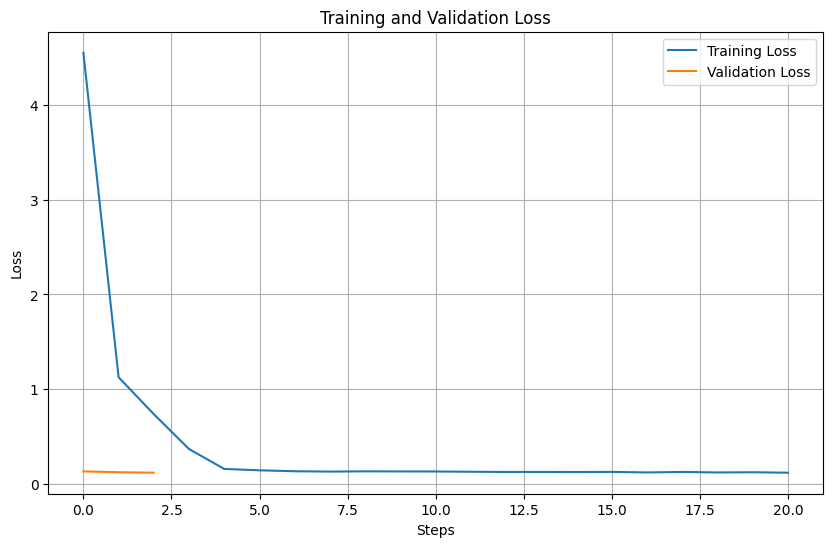

In [24]:
# Cell 20: Performance Analysis and Visualization
# Plot training history (if available)
def plot_training_history(trainer):
    """Plot training and validation loss"""
    if hasattr(trainer.state, 'log_history'):
        history = trainer.state.log_history

        train_loss = [x['loss'] for x in history if 'loss' in x]
        eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(eval_loss, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# Try to plot if history is available
try:
    plot_training_history(trainer)
except:
    print("Training history not available for plotting")

In [25]:
# Cell 21: Model Comparison (Baseline vs Fine-tuned)
def compare_models(questions):
    """Compare baseline model with fine-tuned model"""
    # Load baseline model
    baseline_model = AutoModelForCausalLM.from_pretrained(model_name)
    baseline_tokenizer = AutoTokenizer.from_pretrained(model_name)

    print("Model Comparison:")
    print("=" * 50)

    for question in questions:
        # Fine-tuned model response
        ft_response = generate_response(question)

        # Baseline model response (you would need to implement this similarly)
        print(f"Q: {question}")
        print(f"Fine-tuned: {ft_response}")
        print("-" * 40)

# Compare with sample questions
sample_questions = ["What are symptoms of typhoid?", "How to prevent malaria?"]
compare_models(sample_questions)

Model Comparison:
Q: What are symptoms of typhoid?
Fine-tuned: Typhoid symptoms include prolonged fever, stomach pain, headache, and weakness. Please consult a healthcare provider for diagnosis.
----------------------------------------
Q: How to prevent malaria?
Fine-tuned: You can protect yourself from malaria by sleeping under an insecticide-treated mosquito net, wearing long sleeves in the evening, and using mosquito repellents. Seek medical attention if you develop fever or chills. Seek medical attention if you develop headache. Seek medical attention if you develop weakness. Seek medical attention if you develop weakness. Seek medical attention if you develop pneumonia. Seek medical attention if you develop chills. Seek medical attention if you develop a fever or chills. Seek medical attention if you
----------------------------------------


In [26]:
# Cell 22: Export Demo Code
# Create a standalone script for deployment
demo_code = """
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the fine-tuned model
model_path = "./medical-chatbot-final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

def generate_response(question, max_length=100):
    input_text = f"User: {question}\\nAssistant:"
    inputs = tokenizer.encode(input_text, return_tensors="pt")

    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=len(inputs[0]) + max_length,
            num_return_sequences=1,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    assistant_response = response.split("Assistant:")[-1].strip()
    return assistant_response

def chat_with_bot(message, history):
    return generate_response(message)

demo = gr.ChatInterface(
    fn=chat_with_bot,
    title="Medical Chatbot - Healthcare Assistant",
    description="Ask me questions about healthcare, symptoms, diseases, and medical advice.",
    examples=[
        "What are early signs of pneumonia?",
        "How can I protect myself from malaria?",
        "What should I do if I have high fever?"
    ]
)

if __name__ == "__main__":
    demo.launch(share=True)
"""

with open("medical_chatbot_demo.py", "w") as f:
    f.write(demo_code)

print("Demo code exported to 'medical_chatbot_demo.py'")

Demo code exported to 'medical_chatbot_demo.py'


In [27]:
# Cell 23: Project Summary and Results
print("PROJECT SUMMARY")
print("=" * 50)
print(f"Domain: Healthcare")
print(f"Model: DialoGPT-medium (Fine-tuned)")
print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Test Samples: {len(test_df)}")
print(f"Categories Covered: {df['category'].nunique()}")

print("\nPERFORMANCE METRICS:")
try:
    print(f"BLEU Score: {bleu_score['bleu']:.4f}")
    print(f"ROUGE-1: {rouge_score['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_score['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")
except:
    print("Run evaluation cells to see metrics")

print("\nNEXT STEPS:")
print("1. Run: python medical_chatbot_demo.py to launch the interface")
print("2. Share the public Gradio link for demo")
print("3. Create 5-10 minute demo video")
print("4. Submit PDF report with GitHub repository link")

PROJECT SUMMARY
Domain: Healthcare
Model: DialoGPT-medium (Fine-tuned)
Training Samples: 1400
Validation Samples: 300
Test Samples: 300
Categories Covered: 9

PERFORMANCE METRICS:
BLEU Score: 0.1706
ROUGE-1: 0.3301
ROUGE-2: 0.3205
ROUGE-L: 0.3337

NEXT STEPS:
1. Run: python medical_chatbot_demo.py to launch the interface
2. Share the public Gradio link for demo
3. Create 5-10 minute demo video
4. Submit PDF report with GitHub repository link


In [28]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
!cp -r /content/medical-chatbot /content/drive/MyDrive/
!cp -r /content/medical-chatbot-final /content/drive/MyDrive/
!cp -r /content/wandb /content/drive/MyDrive/
!cp -r /content/medical_chatbot_demo.py /content/drive/MyDrive/
!cp -r /content/medibot_dataset.json /content/drive/MyDrive/






^C
^C
